In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

/Users/opheliaming/opt/anaconda3/envs/py37/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/opheliaming/opt/anaconda3/envs/py37/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/opheliaming/opt/anaconda3/envs/py37/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [2]:
user = pd.read_csv('user_table.csv', parse_dates=['signup_date'])
user.head()

,user_id,signup_date
0,34,2015-01-01
1,59,2015-01-01
2,178,2015-01-01
3,285,2015-01-01
4,383,2015-01-01


In [3]:
user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 2 columns):
user_id        100000 non-null int64
signup_date    100000 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.5 MB


In [4]:
test = pd.read_csv('test_table.csv', parse_dates=['date'])
test.head()

,user_id,date,browser,test,pages_visited
0,600597,2015-08-13,IE,0,2
1,4410028,2015-08-26,Chrome,1,5
2,6004777,2015-08-17,Chrome,0,8
3,5990330,2015-08-27,Safari,0,8
4,3622310,2015-08-07,Firefox,0,1


In [5]:
# join user and test table
data = pd.merge(left=user, right=test, on='user_id', how='left')
data.head()

,user_id,signup_date,date,browser,test,pages_visited
0,34,2015-01-01,2015-08-15,Chrome,0,6
1,59,2015-01-01,2015-08-12,Chrome,1,6
2,178,2015-01-01,2015-08-10,Safari,1,3
3,285,2015-01-01,2015-08-03,Opera,0,5
4,383,2015-01-01,2015-08-05,Firefox,1,9


## Question 1

Is the test winning? That is, should 100% of the users see the Recommended Friends feature?

In [6]:
data.groupby('test')['pages_visited'].mean()

test
0    4.608394
1    4.599693
Name: pages_visited, dtype: float64

In [7]:
# perform student's t-test
control_page = data[data['test'] == 0]['pages_visited'].values
experiment_page = data[data['test'] == 1]['pages_visited'].values

print('T-test:\t', ttest_ind(a=control_page, b=experiment_page, equal_var=False))

T-test:	 Ttest_indResult(statistic=0.5571118435554797, pvalue=0.5774523171559118)


From above analysis, we can find that p-value is $0.577$, which is much larger than $5\%$, so we fail to reject the null hypothesis that there is no difference between control and experiment group.

So, the test doesn't win at tall. This shouldn't expand to all users.

## Question 2
Is the test performing similarly for all user segments or are there differences among different segments?

In [9]:
# process the data
data['interval'] = (data['date'] - data['signup_date']).apply(lambda x: x.days)
data['is_first'] = (data['interval'] == 0).astype(int)
data['dayofweek'] = data['date'].apply(lambda x: x.dayofweek)

data.head()

,user_id,signup_date,date,browser,test,pages_visited,interval,is_first,dayofweek
0,34,2015-01-01,2015-08-15,Chrome,0,6,226,0,5
1,59,2015-01-01,2015-08-12,Chrome,1,6,223,0,2
2,178,2015-01-01,2015-08-10,Safari,1,3,221,0,0
3,285,2015-01-01,2015-08-03,Opera,0,5,214,0,0
4,383,2015-01-01,2015-08-05,Firefox,1,9,216,0,2


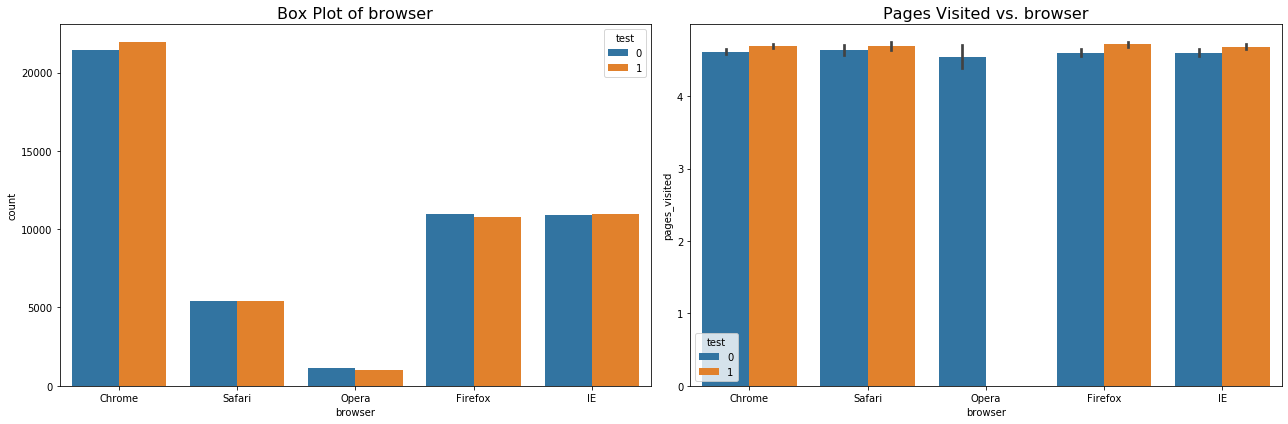

In [10]:
# visualization of browser
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='browser', hue='test', data=data, ax=ax[0])
ax[0].set_title('Box Plot of browser', fontsize=16)

sns.barplot(x='browser', y='pages_visited', hue='test', data=data, ax=ax[1])
ax[1].set_title('Pages Visited vs. browser', fontsize=16)
plt.tight_layout()
plt.show()

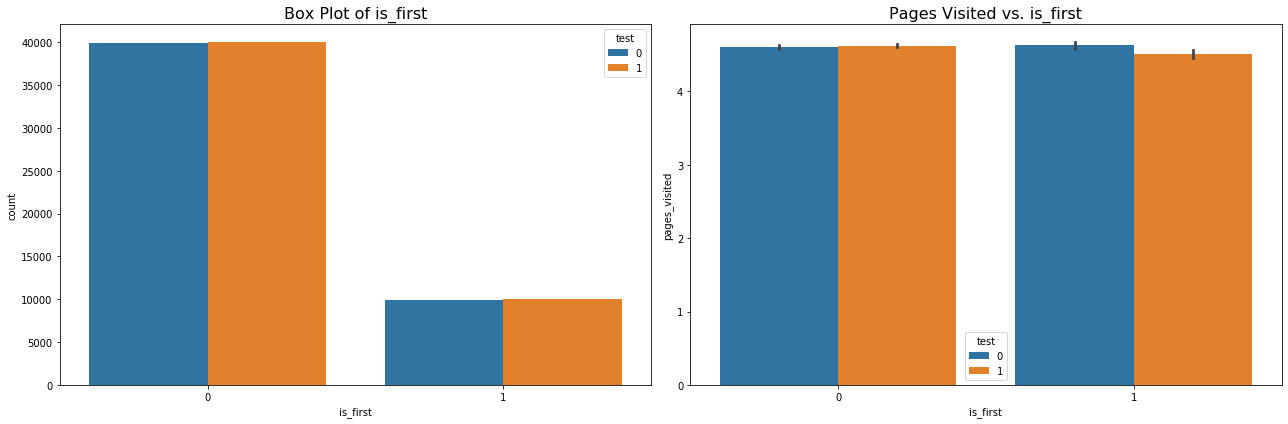

In [11]:
# visualization of is_first
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='is_first', hue='test', data=data, ax=ax[0])
ax[0].set_title('Box Plot of is_first', fontsize=16)

sns.barplot(x='is_first', y='pages_visited', hue='test', data=data, ax=ax[1])
ax[1].set_title('Pages Visited vs. is_first', fontsize=16)
plt.tight_layout()
plt.show()

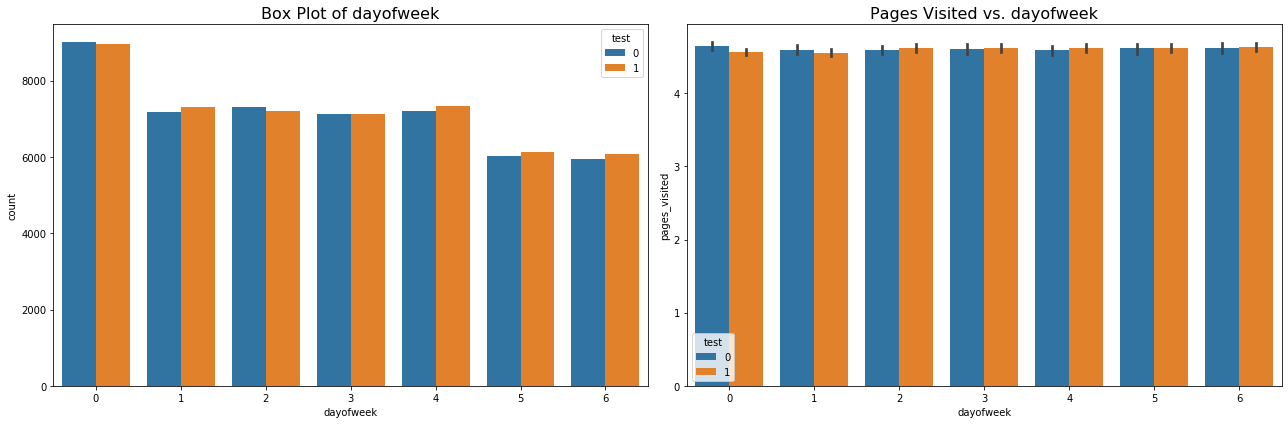

In [12]:
# visualization of dayofweek
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='dayofweek', hue='test', data=data, ax=ax[0])
ax[0].set_title('Box Plot of dayofweek', fontsize=16)

sns.barplot(x='dayofweek', y='pages_visited', hue='test', data=data, ax=ax[1])
ax[1].set_title('Pages Visited vs. dayofweek', fontsize=16)
plt.tight_layout()
plt.show()

## Question 3
If you identified segments that responded differently to the test, can you guess the reason? Would this change your point 1 conclusions?

From the visualization in above part, we can see that the number of pages visited is increased for some factors, such as Chrome, Safari, Firefox, and IE, but the number of pages visited is always 0 for Opera, which shows that there might be some errors or bugs.

If user visit the website right after they signup, the number of pages visited actually get decreased when they are exposed to the new feature.

Also, there are some small difference for day of week.

Now, let's remove the user who use Opera, and conduct t-test again.

In [13]:
subset = data[data['browser'] != 'Opera']
subset.groupby('test')['pages_visited'].mean()

test
0    4.609804
1    4.694989
Name: pages_visited, dtype: float64

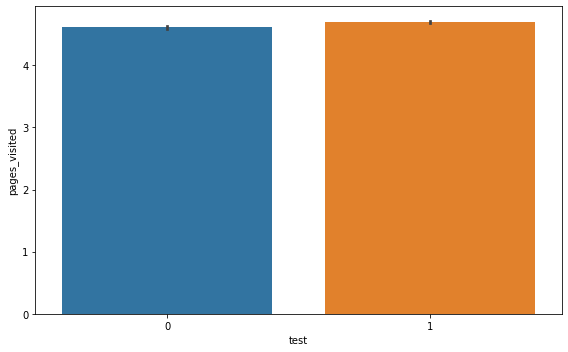

In [14]:
# visualization
fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(x='test', y='pages_visited', data=subset, ax=ax)
plt.tight_layout()
plt.show()

In [15]:
# perform student's t-test
control_page = subset[subset['test'] == 0]['pages_visited'].values
experiment_page = subset[subset['test'] == 1]['pages_visited'].values

print('T-test:\t', ttest_ind(a=control_page, b=experiment_page, equal_var=False))

T-test:	 Ttest_indResult(statistic=-5.474295518566027, pvalue=4.403954129457701e-08)


So, it's clear that after removing the records with Opera browser, the new feature becomes significantly useful. So, I would suggest expanding this feature to other users.

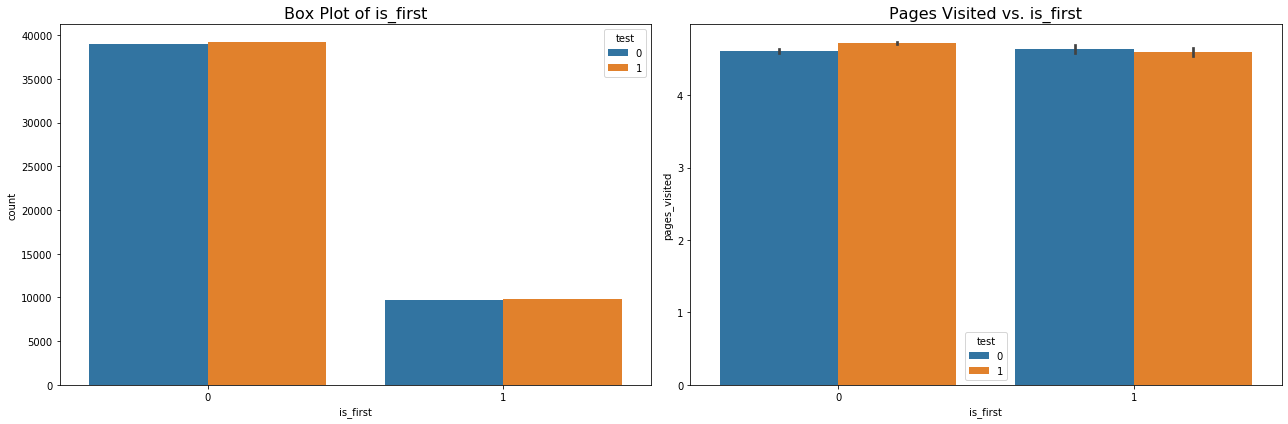

In [16]:
# visualization of is_first
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='is_first', hue='test', data=subset, ax=ax[0])
ax[0].set_title('Box Plot of is_first', fontsize=16)

sns.barplot(x='is_first', y='pages_visited', hue='test', data=subset, ax=ax[1])
ax[1].set_title('Pages Visited vs. is_first', fontsize=16)
plt.tight_layout()
plt.show()